In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
assert sys.version_info >= (3, 5)

from pathlib import Path
from pprint import pprint
import glob
import shutil
import itertools
import pandas as pd
import numpy as np
from typing import List

import tensorflow as tf
from tensorflow import keras
# assert tf.__version__ >= "2.0"
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
AUTO     = tf.data.experimental.AUTOTUNE
# REPLICAS = strategy.num_replicas_in_sync
# print(f'REPLICAS: {REPLICAS}')

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential, Model

# To plot pretty figures
# import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

import cv2
import openslide

# Seed
np.random.seed(42)

fdir = Path.cwd()
print(fdir)
sys.path.append(str(fdir/'../src'))

# from deephistopath.wsi import filter
from deephistopath.wsi import slide
# from deephistopath.wsi import tiles
from deephistopath.wsi import util

from build_tfrec import (show_img, show_images, encode_categorical,
                         _float_feature, _bytes_feature, _int64_feature,
                         np_img_to_bytes
                        )
from train_nn import get_tfr_fnames
from tf_utils import calc_records_in_tfr_folder, calc_examples_in_tfrecord

/vol/ml/apartin/projects/pdx-histo/nbs
Num GPUs Available:  4


ImportError: cannot import name 'get_tfr_fnames' from 'train_nn' (/vol/ml/apartin/projects/pdx-histo/nbs/../src/train_nn.py)

# Load data

In [26]:
# Global
MAIN_APPDIR = fdir/'../apps'
DATADIR = fdir/'../data'
FILENAME = 'annotations.csv'
TILES_DIR = DATADIR/'tiles_png'
TFR_DIR = DATADIR/'tfrecords'

# Path
tiles_path = DATADIR/'tiles_png'
tfr_path = DATADIR/'tfrecords'

# Load data
appname = 'mm_01'
appdir = MAIN_APPDIR/appname
data = pd.read_csv(appdir/FILENAME)
print(data.shape)

display(data.groupby(['ctype', 'Response']).agg({'smp': 'nunique'}).reset_index().rename(columns={'smp': 'samples'}))

(126, 2609)


,ctype,Response,samples
0,bladder/urothelial,0,4
1,bladder/urothelial,1,4
2,digestive/gastrointestinal,0,22
3,digestive/gastrointestinal,1,22
4,lung,0,12
5,lung,1,12
6,sarcoma/mesothelioma,0,10
7,sarcoma/mesothelioma,1,10
8,skin other,0,4
9,skin other,1,4


In [27]:
# Read data
# data = pd.read_csv(datapath/'data_merged.csv')
# csite_enc = encode_categorical(df=data, label_name='csite', label_value='csite_label')
# ctype_enc = encode_categorical(df=data, label_name='ctype', label_value='ctype_label')
# CSITE_NUM_CLASSES = len(csite_enc.keys())
# CTYPE_NUM_CLASSES = len(ctype_enc.keys())

GE_LEN = sum([1 for c in data.columns if c.startswith('ge_')])
DD_LEN = sum([1 for c in data.columns if c.startswith('dd_')])

In [28]:
# Feature specs (used to read an example from tfrecord)
FEA_SPEC = {
    'ge_vec': tf.io.FixedLenFeature(shape=(GE_LEN,), dtype=tf.float32, default_value=None),
    'dd_vec': tf.io.FixedLenFeature(shape=(DD_LEN,), dtype=tf.float32, default_value=None),    
    
    'smp':      tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 
    'Response': tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 
    'image_id': tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 
    
    'image_raw': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    
    'Sample': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'ctype':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'csite':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),    
    'ctype_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
    'csite_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
}

In [29]:
# Summary of tfrecords
tfr_files = sorted(tfr_path.glob('*.tfrec*'))
print('Number of tfrecords the folder:', len(tfr_files))
# calc_records_in_tfr_folder(tfr_dir=tfr_path)
calc_examples_in_tfrecord(tfr_path=str(tfr_files[0]))

Number of tfrecords the folder: 2587
Number of examples in the tfrecord: 50


Feature types in the tfrecord example:
dict_keys(['Response', 'Sample', 'csite', 'csite_label', 'ctype', 'ctype_label', 'dd_vec', 'ge_vec', 'image_id', 'image_raw', 'smp'])

Bytes (csite):
b'musculoskeletal'
musculoskeletal

Float (csite_label):
tf.Tensor(7, shape=(), dtype=int64)
7

Int (Response):
tf.Tensor(0, shape=(), dtype=int64)
0

Float (ge_vec):
tf.Tensor(
[11.582354   5.5994616  8.199727  10.113818   9.794284  10.207017
  8.45096    9.981105   9.13368    7.906384 ], shape=(10,), dtype=float32)
[11.582354   5.5994616  8.199727  10.113818   9.794284  10.207017
  8.45096    9.981105   9.13368    7.906384 ]

Bytes (image_raw):
(303, 303, 3)


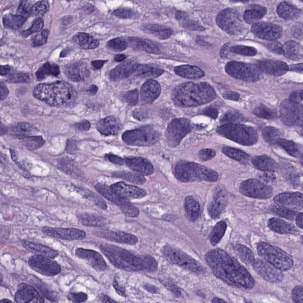

In [30]:
# -----------------------------------------------
# Read single tfrecord and explore single example
# -----------------------------------------------

# Create tf dataset object (from a random tfrecord)
ds = tf.data.TFRecordDataset(str(tfr_files[0]))
# ds = tf.data.TFRecordDataset(filenames=tr_tfr_fnames)

# Get single tfr example
ex = next(ds.__iter__())
ex = tf.io.parse_single_example(ex, features=FEA_SPEC)  # returns features for a given example in a dict
print('Feature types in the tfrecord example:\n{}'.format(ex.keys()))

# Bytes
print('\nBytes (csite):')
print(ex['csite'].numpy())
print(ex['csite'].numpy().decode('UTF-8'))

# Float
print('\nFloat (csite_label):')
print(ex['csite_label'])
print(ex['csite_label'].numpy())

# Int
print('\nInt (Response):')
print(ex['Response'])
print(ex['Response'].numpy())

# Float
print('\nFloat (ge_vec):')
print(ex['ge_vec'][:10])
print(ex['ge_vec'].numpy()[:10])

# Bytes
print('\nBytes (image_raw):')
img = tf.image.decode_jpeg(ex['image_raw'], channels=3)
print(img.numpy().shape)
util.np_to_pil(img.numpy())

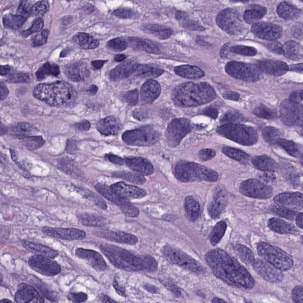

In [31]:
# Get single img
img = ex['image_raw']
img = tf.image.decode_jpeg(img, channels=3)
img = tf.cast(img, tf.float32) / 255.0
# dim = img.shape[0]
img = tf.image.random_flip_left_right(img)
img = tf.image.random_flip_up_down(img)
# img = tf.reshape(img, [dim, dim, 3])
# show_img(img.numpy())
util.np_to_pil(img.numpy())

In [32]:
# -----------------------------------------------
#       Data splits
# -----------------------------------------------
# T/V/E filenames
splitdir = appdir/'splits'
split_id = 0

split_pattern = f'1fold_s{split_id}_*_id.csv'
single_split_files = glob.glob(str(splitdir/split_pattern))
# single_split_files = list(splitdir.glob(split_pattern))

# Get indices for the split
# assert len(single_split_files) >= 2, f'The split {s} contains only one file.'
for id_file in single_split_files:
    if 'tr_id' in id_file:
        tr_id = pd.read_csv(id_file).values.reshape(-1,)
    elif 'vl_id' in id_file:
        vl_id = pd.read_csv(id_file).values.reshape(-1,)
    elif 'te_id' in id_file:
        te_id = pd.read_csv(id_file).values.reshape(-1,)

cv_lists = (tr_id, vl_id, te_id)

# -----------------------------------------------
#       Get data based on splits
# -----------------------------------------------
# Dfs of T/V/E samples
tr_df = data.iloc[tr_id, :].reset_index(drop=True)
vl_df = data.iloc[vl_id, :].reset_index(drop=True)
te_df = data.iloc[te_id, :].reset_index(drop=True)

# List of sample names for T/V/E
tr_smp_names = tr_df['smp'].values
vl_smp_names = vl_df['smp'].values
te_smp_names = te_df['smp'].values

# x_data = data.iloc[idx, :].reset_index(drop=True)
# y_data = np.squeeze(ydata.iloc[idx, :]).reset_index(drop=True)

tr_tfr_fnames = get_tfr_fnames(tr_smp_names)
vl_tfr_fnames = get_tfr_fnames(vl_smp_names)
te_tfr_fnames = get_tfr_fnames(te_smp_names)

In [44]:
# def prepare_image(img, augment=True, dim=256):
def prepare_image(img, augment=True):
    """
    Prepare single image for training. 
    Deotte.
    www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0

    if augment:
        # https://www.tensorflow.org/api_docs/python/tf/image/random_flip_up_down
        # img = transform(img, DIM=dim)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        # img = tf.image.random_saturation(img, 0.7, 1.3)
        # img = tf.image.random_contrast(img, 0.8, 1.2)
        # img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_flip_up_down(img)  # ap

    # img = tf.reshape(img, [dim, dim, 3])  
    return img


# Note! because this func returns inputs and outputs, it's probably must
# change depending on the prediction task 
def read_tfr_example(ex, augment=True):
    """ Read and parse a single example from a tfrecord, and prepare
    inputs and outputs for TF model training.
    """
    ex = tf.io.parse_single_example(ex, FEA_SPEC)

    # Image data
    img = ex['image_raw']
    img = prepare_image(img, augment=augment)  # Deotte

    # Features (RNA and descriptors)
    ge_vec = tf.cast(ex['ge_vec'], tf.float32)
    dd_vec = tf.cast(ex['dd_vec'], tf.float32)

    # Dict of multi-input features
    inputs = {'ge_vec': ge_vec, 'dd_vec': dd_vec, 'img': img}

    # Dict of single-output classifier
    rsp = tf.cast(ex['Response'], tf.int64)
    outputs = {'Response': rsp}

    return inputs, outputs


def get_dataset(files: List[str], cache: bool=True,
                augment: bool=False, shuffle: bool=False, repeat: bool=False, 
                labeled: bool=True, return_image_names: bool=True, batch_size: int=16,
                dim: int=256):
    """ Create and return tf dataset using tfrecord files passed in files.
    
    Args:
        files : list of tfrecord file paths 
    """
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    
    if cache:
        ds = ds.cache()
    
#     if repeat:
#         ds = ds.repeat()
    
#     if shuffle: 
#         ds = ds.shuffle(1024*8)
#         opt = tf.data.Options()
#         opt.experimental_deterministic = False
#         ds = ds.with_options(opt)
        
#     if labeled: 
#         ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
#     else:
#         ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
#                     num_parallel_calls=AUTO)      
    
#     ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
#                                                imgname_or_label), 
#                 num_parallel_calls=AUTO)

    ds = ds.map(lambda ex: read_tfr_example(ex, augment=augment), num_parallel_calls=AUTO)
    
#     ds = ds.batch(batch_size * REPLICAS)
#     ds = ds.prefetch(buffer_size=AUTO)
    return ds

In [64]:
# -----------------------------------------------
# Read single tfrecord and explore single example
# -----------------------------------------------
# ds = tf.data.TFRecordDataset(filenames=tr_tfr_fnames)
# ds = ds.map(lambda ex: read_tfr_example(ex, augment=True))
ds = get_dataset(tr_tfr_fnames)

# Take an example
# ex = next(ds.take(count=1).__iter__())  # creates Dataset with at most 'count' elements from this dataset.
ex = next(ds.__iter__())
print('Inputs: ', ex[0].keys())
print('Outputs:', ex[1].keys())

print('\nInput features:')
for i, fea_name in enumerate(ex[0].keys()):
    print(fea_name, ex[0][fea_name].numpy().shape)
    
print('\nOutputs:')
for i, out_name in enumerate(ex[1].keys()):
    print(out_name, ex[1][out_name].numpy())

Inputs:  dict_keys(['ge_vec', 'dd_vec', 'img'])
Outputs: dict_keys(['Response'])

Input features:
ge_vec (976,)
dd_vec (1613,)
img (303, 303, 3)

Outputs:
Response 0


# Define NN model

In [46]:
# ------------------------------------------
# Define TF Datasets for T/V/E
# ------------------------------------------  
# ds_tr = tf.data.TFRecordDataset(filenames=tr_tfr_fnames)
# ds_vl = tf.data.TFRecordDataset(filenames=vl_tfr_fnames)
# ds_te = tf.data.TFRecordDataset(filenames=te_tfr_fnames)

ds_tr = get_dataset(tr_tfr_fnames)
ds_vl = get_dataset(vl_tfr_fnames)
ds_te = get_dataset(te_tfr_fnames)

In [ ]:
# ------------------------------------------
# Define TF2 model - multimodal
# ------------------------------------------  
initializer = 'he_uniform'
batchnorm = True
dr_rate = 0.2

# ---------------------
# GE
# ---------------------
in_ge = Input(shape=(in_dim_ge,), name='in_ge')
units_ge = [800, 500]

x = layers.Dense(units_ge[0], kernel_initializer=initializer, name='ge_dense_0')(in_ge)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(dr_rate)(x)

x = layers.Dense(units_ge[1], kernel_initializer=initializer, name='ge_dense_1')(x)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
out_ge = layers.Dropout(dr_rate)(x)

ge = Model(inputs=in_ge, outputs=out_ge, name='out_ge')

# ---------------------
# DD
# ---------------------
in_dd = Input(shape=(in_dim_dd,), name='in_dd')
units_dd = [995, 700]

x = layers.Dense(units_dd[0], kernel_initializer=initializer, name='dd_dense_0')(in_dd)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(dr_rate)(x)

x = layers.Dense(units_dd[1], kernel_initializer=initializer, name='dd_dense_1')(x)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
out_dd = layers.Dropout(dr_rate)(x)

dd = Model(inputs=in_dd, outputs=out_dd, name='out_dd')

# ---------------------
# IMG
# ---------------------
in_im = Input(shape=(in_dim_im,), name='in_im')

pass
# tf.keras.applications.EfficientNetB3(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
#     **kwargs
# )
pass

# ---------------------
# Merge towers
mrg = layers.concatenate([ge.output, dd.output, im.output], axis=1)
# units_mrg = [1000, 500, 250, 125]  # original
units_mrg = [500, 250, 125]  # fair

x = layers.Dense(units_mrg[0], kernel_initializer=initializer)(mrg)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(dr_rate)(x)

x = layers.Dense(units_mrg[1], kernel_initializer=initializer)(x)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(dr_rate)(x)

x = layers.Dense(units_mrg[2], kernel_initializer=initializer)(x)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(dr_rate)(x)

# x = layers.Dense(units_mrg[3], kernel_initializer=initializer)(x)
# if batchnorm:
#     x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(dr_rate)(x)

# ---------------------
# Output
outputs = layers.Dense(1, activation='relu', name='bin_response')(x)

# ---------------------
# Input --> Output
model = Model(inputs=[in_ge, in_dd, in_im], outputs=[outputs])

if opt_name.lower() == 'adam':
    opt = keras.optimizers.Adam(learning_rate)
else:
    opt = keras.optimizers.SGD(learning_rate, momentum=0.9)
    
model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
              optimizer=opt,
              metrics=['mae'])

In [ ]:
# Inputs
input_ge = tf.keras.Input(shape=(GE_LEN,), name='ge_vec')
input_dd = tf.keras.Input(shape=(DD_LEN,), name='dd_vec')
input_im = tf.keras.Input(shape=(GE_LEN,), name='img')

# Hidden
fc = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(input_ge)
fc = tf.keras.layers.Dropout(0.2, name='dropout_1')(fc)
fc = tf.keras.layers.Dense(128, activation='relu', name='dense_2')(fc)
fc = tf.keras.layers.Dropout(0.2, name='dropout_2')(fc)

# Output
ctype_out = tf.keras.layers.Dense(CTYPE_NUM_CLASSES, activation='softmax', name='ctype_label')(fc)
csite_out = tf.keras.layers.Dense(CSITE_NUM_CLASSES, activation='softmax', name='csite_label')(fc)
# ctype_out = tf.keras.layers.Dense(1, activation='softmax', name='ctype_label')(fc)
# csite_out = tf.keras.layers.Dense(1, activation='softmax', name='csite_label')(fc)

# Model
model = tf.keras.Model(inputs=[input_ge], outputs=[ctype_out, csite_out])
# model = tf.keras.Model(inputs=[input_ge], outputs=[csite_out])
model.summary()

# ----------
# Compile
# ----------
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.categorical_crossentropy},
#               metrics=[tf.keras.metrics.categorical_crossentropy])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={'csite_label': tf.keras.losses.categorical_crossentropy,
                    'ctype_label': tf.keras.losses.categorical_crossentropy},
              metrics=[tf.keras.metrics.categorical_crossentropy])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.mean_absolute_error},
#               metrics=[tf.keras.metrics.mean_absolute_error])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.mean_absolute_error,
#                     'ctype_label': tf.keras.losses.mean_absolute_error},
#               metrics=[tf.keras.metrics.mean_absolute_error])

In [ ]:
# The choice of categorical_crossentropy vs sparse_categorical_crossentropy depends on the shape of labels depennds
# stackoverflow.com/questions/49161174/tensorflow-logits-and-labels-must-have-the-same-first-dimension
# ================================================================================================================
# history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

history = model.fit(ds_train,
                    epochs=20,
                    validation_data=ds_val,
                    verbose=False)

In [5]:
# Divide the df into smaller dfs
n_tfrecords = 5
d = int(data.shape[0]/n_tfrecords)
dfs = []

for i in range(n_tfrecords):
    i0 = i * d
    i1 = (i + 1) * d
    if i == n_tfrecords - 1:
        i1 = None
    dfs.append(data.iloc[i0:i1])
    
[df.shape for df in dfs]

[(403, 2607), (403, 2607), (403, 2607), (403, 2607), (405, 2607)]

In [6]:
# next(dfs[1].iterrows())[1]
# next(dfs[1].iterrows())[1].index
# next(dfs[1].iterrows())[1].values

# item = next(dfs[1].iterrows())[1]
# ge_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('ge_')]
# dd_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('dd_')]
# item['Sample']

In [9]:
# Create tfrecords
# ----------------
# Ourdir
tfr_out = Path.cwd()/'tfr_from_csv'
os.makedirs(tfr_out, exist_ok=True)

# Randomize the dfs
randomize = False
if randomize:
    import random
    random.shuffle(dfs)
    
n_tr_dfs = 4  # num of train tfr files
n_vl_dfs = 1  # num of val tfr files
tr_sz = 0     # counter for training examples
vl_sz = 0     # counter for val examples

for i, df in enumerate(dfs):
    i += 1

    if i <= n_tr_dfs:
        tfr_fname = tfr_out/f'train_{i}.tfrecord'
        tr_sz += df.shape[0]
    else:
        tfr_fname = tfr_out/f'val_{i}.tfrecord'
        vl_sz += df.shape[0]
        
    # Create tfr writer
    writer = tf.io.TFRecordWriter(str(tfr_fname))

    for i, item in df.iterrows():
        # Prefix rna and drug features
        ge_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('ge_')]
        dd_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('dd_')]
        
        ex = tf.train.Example(features=tf.train.Features(
            feature={
                'ge_vec': tf.train.Feature(float_list=tf.train.FloatList(value=ge_vec)),
                'dd_vec': tf.train.Feature(float_list=tf.train.FloatList(value=dd_vec)),
                'Sample': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(item['Sample'], 'utf-8')])),
                'ctype_label': tf.train.Feature(int64_list=tf.train.Int64List(value=[item['ctype_label']])),
                'csite_label': tf.train.Feature(int64_list=tf.train.Int64List(value=[item['csite_label']])),
                'ctype': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(item['ctype'], 'utf-8')])),
                'csite': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(item['csite'], 'utf-8')]))
            }
        ))
 
        writer.write(ex.SerializeToString())

    writer.close()
    
print(f'Train samples {tr_sz}')
print(f'Val samples   {vl_sz}')

calc_examples_in_tfrecord(str(tfr_out/'val_5.tfrecord'))

Train samples 1612
Val samples   405
Number of examples in the tfrecord: 405


In [16]:
fea_spec = {
    'ge_vec': tf.io.FixedLenFeature(shape=(len(ge_vec),), dtype=tf.float32, default_value=None),
    'dd_vec': tf.io.FixedLenFeature(shape=(len(dd_vec),), dtype=tf.float32, default_value=None),    
    'Sample': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'ctype_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
    'csite_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
    'ctype':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'csite':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
}

ds = tf.data.TFRecordDataset(str(tfr_out/'train_1.tfrecord'))
ex = next(ds.__iter__())
ex = tf.io.parse_single_example(ex, features=fea_spec)
print(ex['csite'].numpy().decode('UTF-8'))
print(ex['csite_label'].numpy())
print(csite_enc)

digestive/gastrointestinal
1
{'bladder/urothelial': 0, 'digestive/gastrointestinal': 1, 'endocrine and neuroendocrine': 2, 'gynecologic': 3, 'head & neck': 4, 'kidney': 5, 'lung': 6, 'musculoskeletal': 7, 'skin': 8}


### Create tf datasets

In [16]:
# csite_classes = data['simplified_tumor_site'].values.tolist()
# ctype_classes = data['simplified_tumor_type'].values.tolist()
# tt = tf.convert_to_tensor(csite_classes)
tt = tf.convert_to_tensor(list(csite_enc.keys()))
tt = tf.data.Dataset.from_tensor_slices(tt)
for i in tt:
    # tf.print(i)
    print(i)

tf.Tensor(b'bladder/urothelial', shape=(), dtype=string)
tf.Tensor(b'digestive/gastrointestinal', shape=(), dtype=string)
tf.Tensor(b'endocrine and neuroendocrine', shape=(), dtype=string)
tf.Tensor(b'gynecologic', shape=(), dtype=string)
tf.Tensor(b'head & neck', shape=(), dtype=string)
tf.Tensor(b'kidney', shape=(), dtype=string)
tf.Tensor(b'lung', shape=(), dtype=string)
tf.Tensor(b'musculoskeletal', shape=(), dtype=string)
tf.Tensor(b'skin', shape=(), dtype=string)


In [18]:
# class Dataset():
    
#     def __init__(self, filenames):
#         self.filenames = filenames
    
#     def define_fea_spec(fea_spec):
#         self.fea_spec = fea_spec

fea_spec = {
    'ge_vec':      tf.io.FixedLenFeature(shape=(976,), dtype=tf.float32, default_value=None),
    'dd_vec':      tf.io.FixedLenFeature(shape=(1613,), dtype=tf.float32, default_value=None),    
    'Sample':      tf.io.FixedLenFeature(shape=[1], dtype=tf.string, default_value=None),
    'ctype_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None),
    'csite_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None),
    'ctype':       tf.io.FixedLenFeature(shape=[1], dtype=tf.string, default_value=None),
    'csite':       tf.io.FixedLenFeature(shape=[1], dtype=tf.string, default_value=None),
}    

def read_tfr_example(ex):
    """ Read and parse a single example from a tfrecord. """
    ex = tf.io.parse_single_example(ex, fea_spec)
    
    # Inputs
    ge_vec = tf.cast(ex['ge_vec'], tf.float32)
    dd_vec = tf.cast(ex['dd_vec'], tf.float32)
    inputs = {'ge_vec': ge_vec}
    
    # Outputs
    csite_label = tf.cast(ex['csite_label'], tf.int64)
    ctype_label = tf.cast(ex['ctype_label'], tf.int64)
    
    # One-hot
    csite_label = tf.one_hot(indices=csite_label, depth=CSITE_NUM_CLASSES, on_value=1.0, off_value=0.0)
    ctype_label = tf.one_hot(indices=ctype_label, depth=CTYPE_NUM_CLASSES, on_value=1.0, off_value=0.0)
    
    csite_label = tf.reshape(csite_label, [CSITE_NUM_CLASSES,])
    ctype_label = tf.reshape(ctype_label, [CTYPE_NUM_CLASSES,])    
    
    # Put into dict
#     outputs = {'csite_label': csite_label}
    outputs = {'csite_label': csite_label, 'ctype_label': ctype_label}
    return inputs, outputs


# Train and val filenames
train_filenames = glob(os.path.join(tfr_out, 'train*.tfrecord'))
val_filenames   = glob(os.path.join(tfr_out, 'val*.tfrecord'))

ds = tf.data.TFRecordDataset(filenames=train_filenames)
ds = ds.map(read_tfr_example)

# Take an example
ii = next(ds.take(1).__iter__())
print('Inputs: ', ii[0].keys())
print('Outputs:', ii[1].keys())

# print(ii[0]['ge_vec'].numpy().shape)
for i, k in enumerate(ii[0].keys()):
    print(k, ii[0][k].numpy().shape)
    
# print(ii[1]['csite_label'].numpy())
# print(ii[1]['ctype_label'].numpy())
for i, k in enumerate(ii[1].keys()):
    print(k, ii[1][k].numpy().shape)

Inputs:  dict_keys(['ge_vec'])
Outputs: dict_keys(['csite_label', 'ctype_label'])
ge_vec (976,)
csite_label (9,)
ctype_label (11,)


In [18]:
# read this:  https://www.tensorflow.org/datasets/performances
def get_tfr_dataset(filenames):
    """ Create tf dataset. """
    ds = tf.data.TFRecordDataset(filenames=filenames)
    ds = ds.shuffle(500, reshuffle_each_iteration=True)
    ds = ds.map(read_tfr_example)
    # ds = ds.batch(32, drop_remainder=True)
    ds = ds.batch(32)
    return ds

ds_train = get_tfr_dataset(train_filenames)
ds_val   = get_tfr_dataset(val_filenames)

# Take a sample
ii = next(ds_train.take(1).__iter__())
# ii = next(ds_val.take(1).__iter__())
print('Inputs: ', ii[0].keys())
print('Outputs:', ii[1].keys())

# print(ii[0]['ge_vec'].numpy().shape)
# print(ii[1]['csite_label'].numpy().shape)
# print(ii[1]['ctype_label'].numpy().shape)

# print(ii[0]['ge_vec'].numpy().shape)
for i, k in enumerate(ii[0].keys()):
    print(k, ii[0][k].numpy().shape)
    
# print(ii[1]['csite_label'].numpy())
# print(ii[1]['ctype_label'].numpy())
for i, k in enumerate(ii[1].keys()):
    print(k, ii[1][k].numpy().shape)

Inputs:  dict_keys(['ge_vec'])
Outputs: dict_keys(['csite_label', 'ctype_label'])
ge_vec (32, 976)
csite_label (32, 9)
ctype_label (32, 11)


In [19]:
# def preprocess(ex):
#     ex = tf.io.parse_single_example(ex, features=fea_spec)
#     # sample = ex['Sample'][0].numpy().decode('utf-8')
#     sample = tf.cast(ex['Sample'], tf.string)
#     return sample

# # Train dataset
# ds = tf.data.TFRecordDataset(filenames=train_filenames)
# ds = ds.map(preprocess)
# ds = ds.shuffle(500, reshuffle_each_iteration=True)
# # ds = ds.batch(64)
# ii = next(ds.take(1).__iter__())
# print(ii[0].numpy().decode('utf-8'))

In [20]:
# Toy dataset
# -----------
# def power_two(x):
#     return x**2

# ds = tf.data.Dataset.range(10)
# ds = ds.map(power_two)
# ds = ds.repeat(1)
# ds = ds.shuffle(100, reshuffle_each_iteration=True)
# ds = ds.batch(2)
# for i, item in enumerate(ds):
#     tf.print(item, end=' ')

### Train Keras Type Classifier

In [21]:
import tensorflow as tf

# Inputs
input_ge = tf.keras.Input(shape=(len(ge_vec),), name='ge_vec')

# Hidden
fc = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(input_ge)
fc = tf.keras.layers.Dropout(0.2, name='dropout_1')(fc)
fc = tf.keras.layers.Dense(128, activation='relu', name='dense_2')(fc)
fc = tf.keras.layers.Dropout(0.2, name='dropout_2')(fc)

# Output
ctype_out = tf.keras.layers.Dense(CTYPE_NUM_CLASSES, activation='softmax', name='ctype_label')(fc)
csite_out = tf.keras.layers.Dense(CSITE_NUM_CLASSES, activation='softmax', name='csite_label')(fc)
# ctype_out = tf.keras.layers.Dense(1, activation='softmax', name='ctype_label')(fc)
# csite_out = tf.keras.layers.Dense(1, activation='softmax', name='csite_label')(fc)

# Model
model = tf.keras.Model(inputs=[input_ge], outputs=[ctype_out, csite_out])
# model = tf.keras.Model(inputs=[input_ge], outputs=[csite_out])
model.summary()

# ----------
# Compile
# ----------
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.categorical_crossentropy},
#               metrics=[tf.keras.metrics.categorical_crossentropy])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={'csite_label': tf.keras.losses.categorical_crossentropy,
                    'ctype_label': tf.keras.losses.categorical_crossentropy},
              metrics=[tf.keras.metrics.categorical_crossentropy])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.mean_absolute_error},
#               metrics=[tf.keras.metrics.mean_absolute_error])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.mean_absolute_error,
#                     'ctype_label': tf.keras.losses.mean_absolute_error},
#               metrics=[tf.keras.metrics.mean_absolute_error])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ge_vec (InputLayer)             [(None, 976)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          125056      ge_vec[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       dropout_1[0][0]                  
_______________________________________________________________________________________

In [22]:
# The choice of categorical_crossentropy vs sparse_categorical_crossentropy depends on the shape of labels depennds
# stackoverflow.com/questions/49161174/tensorflow-logits-and-labels-must-have-the-same-first-dimension
# ================================================================================================================
# history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

history = model.fit(ds_train,
                    epochs=20,
                    validation_data=ds_val,
                    verbose=False)

In [23]:
result = model.evaluate(ds_val, verbose=False)
dict(zip(model.metrics_names, result))

{'loss': 0.9979113936424255,
 'ctype_label_loss': 0.5338507890701294,
 'csite_label_loss': 0.4640606641769409,
 'ctype_label_categorical_crossentropy': 0.5338507890701294,
 'csite_label_categorical_crossentropy': 0.4640606641769409}

In [24]:
rr = model.predict(ds_val.repeat(1))
if isinstance(rr, list):
    print(rr[0].shape)
    print(rr[1].shape)
else:
    print(rr.shape)

(405, 11)
(405, 9)


In [78]:
for i, item in enumerate(ds_val):
    pass # print(item)
print(i)
print(ii[0]['ge_vec'].shape)
print(ii[1]['csite_label'].shape)
# print(ii[1]['ctype_label'].shape)

11
(32, 976)
(32, 1)


288